In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

file = "dataR2.csv"
df = pd.read_csv(file)
X = df.drop(columns=["Classification"])
y = df["Classification"]



In [2]:
import numpy as np
from scipy.stats import kruskal

#--------------------------feature selection --------------------------
#Kruskal-Wallis
kruskal_selected_features = []
p_values = {}
classes = np.unique(y)
 
for feature in X.columns:
    groups = []
    for have_c in classes:
        groups.append(X.loc[y == have_c, feature]) #faz uma lista dependendo do valor do classification

    stat, p = kruskal(*groups) #stat fica com o valor H e p fica com o p-value
    p_values[feature] = p
    
    # Selecionar features com diferença estatisticamente significativa  (5% significance level)
    if p < 0.05:
        kruskal_selected_features.append(feature)
        print(f"Feature: {feature}, Kruskal-Wallis H-statistic: {stat}, p-value: {p}")

print("kruskal_selected_features:", kruskal_selected_features)
# ROC-AUC
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
from plotly.subplots import make_subplots
import math


# --- prepara dados (y_train e X_train já definidos) ---
classes = np.unique(y)
pos_label = classes[-1]   # define a classe positiva como a de maior valor (ex: 1 ou 2)


fnames = np.array(X.columns)
roc_auc = np.zeros(fnames.shape)


# --- calcular número de linhas e colunas para a grelha ---
n_features = len(fnames)
cols = 2  # alterado para 2 colunas
rows = math.ceil(n_features / cols)


# --- criar grelha de subplots ---
figR = make_subplots(
    rows=rows, 
    cols=cols,
    subplot_titles=[f for f in fnames],
    horizontal_spacing=0.1,
    vertical_spacing=0.1
)


# --- calcular curvas ROC e AUC para cada feature ---
i = 0
for idx, f in enumerate(fnames):
    x_feat = X[f].to_numpy().astype(float)
    y_true = y.to_numpy()


    # curva ROC + AUC
    fpr, tpr, _ = roc_curve(y_true, x_feat, pos_label=pos_label)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1 - a  # inverter direção se necessário
    roc_auc[i] = a


    # calcular posição na grelha
    row = (idx // cols) + 1
    col = (idx % cols) + 1


    # adicionar trace ao subplot específico com cor fixa
    figR.add_scatter(
        x=fpr, 
        y=tpr, 
        mode='lines+markers',
        line=dict(color='#636EFA'),  # cor azul padrão do plotly
        marker=dict(color='#636EFA'),
        showlegend=False,
        row=row, 
        col=col
    )


    # adicionar anotação com AUC
    figR.add_annotation(
        x=0.5, y=0.5,
        text=f"AUC: {a:.3f}",
        showarrow=False,
        yshift=10,
        row=row, col=col
    )


    i += 1


# --- configurar layout ---
figR.update_xaxes(title_text="1 - Specificidade (FPR)", range=[-0.01, 1.01])
figR.update_yaxes(title_text="Sensibilidade (TPR)", range=[-0.01, 1.01])


figR.update_layout(
    autosize=False,
    height=700 * rows,
    width=1400,  # ajustado para 2 colunas
    showlegend=False
)


figR.show()



# --- selecionar features com AUC acima do limiar (ex: 0.60) ---
roc_auc_selected_features = fnames[roc_auc > 0.60]
print("roc_auc_selected_features:", roc_auc_selected_features)


# Matriz de Correlação entre todas as features (treino)
import plotly.express as px
X_roc = X[kruskal_selected_features]
eatures = X_roc.columns.tolist()

X_roc = X_roc.to_numpy().T
corrMat = np.corrcoef(X_roc)
fig = px.imshow(
    corrMat,
    text_auto=True,
    labels=dict(x="Features", y="Features", color="Correlação"),
    x=eatures,
    y=eatures,
    width=1000,
    height=1000,
    color_continuous_scale=px.colors.sequential.gray
)
fig.update_layout(title="Matriz de Correlação entre TODAS as Features (Treino)")
fig.show()
X = X[kruskal_selected_features]

# (80%) de treino e validaçao / (20%) de teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 60% de treino / 20% de validação 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Tamanho treino:      {len(X_train)}")
print(f"Tamanho validação:   {len(X_val)}")
print(f"Tamanho teste:       {len(X_test)}")
X
X_train.to_csv("X_train.csv", index=False)


Feature: Glucose, Kruskal-Wallis H-statistic: 23.91957997825514, p-value: 1.0044494847229907e-06
Feature: Insulin, Kruskal-Wallis H-statistic: 4.931023337417101, p-value: 0.026378691997257887
Feature: HOMA, Kruskal-Wallis H-statistic: 8.887111686390483, p-value: 0.0028719068810340023
Feature: Resistin, Kruskal-Wallis H-statistic: 9.699241863905343, p-value: 0.0018434405032271757
kruskal_selected_features: ['Glucose', 'Insulin', 'HOMA', 'Resistin']


roc_auc_selected_features: ['Glucose' 'Insulin' 'HOMA' 'Resistin']


Tamanho treino:      69
Tamanho validação:   23
Tamanho teste:       24


In [3]:
#Removemos a insulina pq tem alta correlaçao com a homa mas tem um p-value mais alto 
#kruskal_selected_features.remove('Insulin')


In [4]:
# --------------------dimensionality reduction  -----

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Usar as FEATURES SELECIONADAS pelo Kruskal-Wallis (após remover Insulin)
X_train_array = X_train.to_numpy()  # features selecionadas
X_val_array = X_val.to_numpy()      # features selecionadas
X_test_array = X_test.to_numpy()    # features selecionadas
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_array)  # fit ONLY on training

# Normalizar validação e teste com os parâmetros do treino
X_val_std = scaler.transform(X_val_array)  # transform usando parâmetros do treino
X_test_std = scaler.transform(X_test_array)  # transform usando parâmetros do treino

# PCAcom dados de treino
pca = PCA()
pca.fit(X_train_std)

print("PCA eigenvalues/Explained variance")
print(pca.explained_variance_)
print("Sum of eigenvalues="+str(np.sum(pca.explained_variance_)))
#PCA eigenvectors/Principal components
print("PCA eigenvectors/Principal components")
W=pca.components_.T
print(W)


fig = px.scatter(x= np.arange(1, len(pca.explained_variance_) + 1), y=pca.explained_variance_,labels=dict(x="PC",y="Explained Variance"))
fig.add_hline(y=1,line_width=3, line_dash="dash", line_color="red")
fig.update_traces(marker_size=10)
fig.show()

print("Variance (%) retained accourding to Kaiser: "+str(pca.explained_variance_[0]**2/(np.sum(pca.explained_variance_**2))*100))

print("Variance (%) retained accourding to Scree: "+str(np.sum(pca.explained_variance_[0:3]**2)/(np.sum(pca.explained_variance_**2))*100))

#PCA com n_components=1 no treino
pca = PCA(n_components=2)
X_train_do_reduction_pca = pca.fit_transform(X_train_std)  # fit_transform ONLY on training

# PCA validação e teste
X_val_do_reduction_pca = pca.transform(X_val_std)  # transform usando o PCA do treino
X_test_do_reduction_pca = pca.transform(X_test_std)  # transform usando o PCA do treino



PCA eigenvalues/Explained variance
[2.66317327 0.94641169 0.41561352 0.03362505]
Sum of eigenvalues=4.0588235294117645
PCA eigenvectors/Principal components
[[ 0.52276621  0.12785984  0.80500912 -0.24965512]
 [ 0.55347396 -0.29792031 -0.4975053  -0.59782818]
 [ 0.59265706 -0.24047764 -0.11075854  0.76069748]
 [ 0.26294423  0.91491303 -0.30361381  0.04016387]]


Variance (%) retained accourding to Kaiser: 86.89593862394149
Variance (%) retained accourding to Scree: 99.98614755080267


In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import plotly.express as px
import pandas as pd

# Ajustar LDA APENAS com dados de treino
lda = LinearDiscriminantAnalysis()

# Transformar treino, validação e teste usando o LDA aprendido
X_train_lda_transformed = lda.fit_transform(X_train_std, y_train)
X_val_lda_transformed = lda.transform(X_val_std)
X_test_lda_transformed = lda.transform(X_test_std)

#Plot transformed data (treino)
fig = px.scatter(x=X_train_lda_transformed[:,0], y=np.zeros_like(X_train_lda_transformed[:,0]), color=y_train.astype(str), labels=dict(x="LDA1", y="", color="Class"))
fig.update_traces(marker_size=10)

In [6]:

# MDC Euclidean a seguir o LDA
X = X_test_lda_transformed

y = y_test.to_numpy()

ix_1 = np.where(y == 1)[0]
ix_2 = np.where(y == 2)[0]

mu1 = np.array([np.mean(X[ix_1], axis=0)]).T
mu2 = np.array([np.mean(X[ix_2], axis=0)]).T

# Classificação usando MDC
yrtp = np.ones(len(y))
dx = ((mu1-mu2).T @ (X.T - 0.5*(mu1+mu2))).flatten()
yrtp[dx < 0] = 2

TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]


SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("\n--- Métricas de Performance (MDC a seguir o LDA) ---")

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))




--- Métricas de Performance (MDC a seguir o LDA) ---
Sensitivity(%)=72.72727272727273
Specificity(%)=46.15384615384615
Precision(%)=53.333333333333336
F1Score(%)=61.53846153846153
Accuracy(%)=58.333333333333336


In [7]:
# Médias no espaço LDA
mu1 = np.array([np.mean(X[ix_1], axis=0)]).T
mu2 = np.array([np.mean(X[ix_2], axis=0)]).T

# ------ Mahalanobis: covariância pooled e sua inversa ------

C1 = np.cov(X[ix_1], rowvar=False, bias=False)
C2 = np.cov(X[ix_2], rowvar=False, bias=False)
C1 = np.atleast_2d(C1)   # garante matriz mesmo em 1D
C2 = np.atleast_2d(C2)
C  = (C1+C2)/2

# inversa estável
Ci = np.linalg.inv(C)

# ------ Classificação MDC (Mahalanobis) ------
yrtp = np.ones(len(y), dtype=int)
dx = ((mu1 - mu2).T @ Ci @ (X.T - 0.5*(mu1 + mu2))).flatten()
yrtp[dx < 0] = 2

# ------ Métricas ------
TPTr = np.shape(np.where((y[ix_1] == yrtp[ix_1]))[0])[0]
TNTr = np.shape(np.where((y[ix_2] == yrtp[ix_2]))[0])[0]
FPTr = np.shape(np.where((y[ix_2] != yrtp[ix_2]))[0])[0]
FNTr = np.shape(np.where((y[ix_1] != yrtp[ix_1]))[0])[0]

SSTr = TPTr/(TPTr+FNTr) if (TPTr+FNTr) else 0.0
SPTr = TNTr/(TNTr+FPTr) if (TNTr+FPTr) else 0.0
PRTr = TPTr/(TPTr+FPTr) if (TPTr+FPTr) else 0.0
F1ScoreTr = 2*(PRTr*SSTr)/(PRTr+SSTr) if (PRTr+SSTr) else 0.0
ACTr = (TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("\n--- Métricas de Performance (MDC após LDA - Mahalanobis) ---")
print("Sensitivity(%)=" + str(SSTr*100))
print("Specificity(%)=" + str(SPTr*100))
print("Precision(%)="   + str(PRTr*100))
print("F1Score(%)="    + str(F1ScoreTr*100))
print("Accuracy(%)="   + str(ACTr*100))



--- Métricas de Performance (MDC após LDA - Mahalanobis) ---
Sensitivity(%)=72.72727272727273
Specificity(%)=46.15384615384615
Precision(%)=53.333333333333336
F1Score(%)=61.53846153846153
Accuracy(%)=58.333333333333336


In [8]:



#------ Fisher ------
S1=(X[ix_1,:].T-mu1)@(X[ix_1,:].T-mu1).T
S2=(X[ix_2,:].T-mu2)@(X[ix_2,:].T-mu2).T

Sw=S1+S2
SwInv=np.linalg.inv(Sw)

w=SwInv@(mu1-mu2)

b=-0.5*(w.T@mu1+w.T@mu2)

yrtp=np.ones(np.shape(y))

dx=(w.T@X.T + b).flatten()
yrtp[dx<0]=2


TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]


SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))




Sensitivity(%)=72.72727272727273
Specificity(%)=46.15384615384615
Precision(%)=53.333333333333336
F1Score(%)=61.53846153846153
Accuracy(%)=58.333333333333336


In [9]:
X=X_test_do_reduction_pca

y = y_test.to_numpy()

ix_1 = np.where(y == 1)[0]
ix_2 = np.where(y == 2)[0]

mu1 = np.array([np.mean(X[ix_1], axis=0)]).T
mu2 = np.array([np.mean(X[ix_2], axis=0)]).T

yrtp = np.ones(np.shape(y))
dx = ((mu1 - mu2).T @ (X.T - 0.5*(mu1+mu2))).flatten()
yrtp[dx < 0] = 2

TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]
SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("\n--- Métricas de Performance (MDC  a seguir o PCA) ---")
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))





--- Métricas de Performance (MDC  a seguir o PCA) ---
Sensitivity(%)=100.0
Specificity(%)=30.76923076923077
Precision(%)=55.00000000000001
F1Score(%)=70.96774193548387
Accuracy(%)=62.5


In [10]:
#MDC Mahalanobis a seguir PCA
C1 = np.cov(X[ix_1].T)


C2 = np.cov(X[ix_2].T)



C  = (C1+C2)/2

# inversa estável
Ci = np.linalg.inv(C)

yrtp = np.ones(len(y), dtype=int)
dx = ((mu1 - mu2).T @ Ci @ (X.T - 0.5*(mu1 + mu2))).flatten()
yrtp[dx < 0] = 2


TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]
SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("\n--- Métricas de Performance (MDC  a seguir o PCA) ---")
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))





--- Métricas de Performance (MDC  a seguir o PCA) ---
Sensitivity(%)=72.72727272727273
Specificity(%)=38.46153846153847
Precision(%)=50.0
F1Score(%)=59.25925925925925
Accuracy(%)=54.166666666666664


In [11]:
#------ Fisher ------


S1=(X[ix_1,:].T-mu1)@(X[ix_1,:].T-mu1).T
S2=(X[ix_2,:].T-mu2)@(X[ix_2,:].T-mu2).T

Sw=S1+S2
SwInv=np.linalg.inv(Sw)

w=SwInv@(mu1-mu2)

b=-0.5*(w.T@mu1+w.T@mu2)

yrtp=np.ones(np.shape(y))

dx=(w.T@X.T + b).flatten()
yrtp[dx<0]=2


TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]


SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))


Sensitivity(%)=72.72727272727273
Specificity(%)=38.46153846153847
Precision(%)=50.0
F1Score(%)=59.25925925925925
Accuracy(%)=54.166666666666664


In [12]:
from sklearn import mixture
def fitBayes(Xtr,ytr):
    ix1=np.where(ytr==1)[0]
    ix2=np.where(ytr==2)[0]
    
    #Compute priors
    Pw1=ix1.shape[0]/(ix1.shape[0]+ix2.shape[0])
    Pw2=ix2.shape[0]/(ix1.shape[0]+ix2.shape[0])
    
    # Estimate gaussian conditional PDFs --> fit two Gaussian Mixture Models
    clf1 = mixture.GaussianMixture(n_components=1)
    clf2 = mixture.GaussianMixture(n_components=1)
    mod1=clf1.fit(Xtr[ix1,:])
    mod2=clf2.fit(Xtr[ix2,:])
    
    return {'mean1':mod1.means_.squeeze(),'mean2':mod2.means_.squeeze(),
            'cov1':mod1.covariances_[0],'cov2':mod2.covariances_[0],
            'Pw1':Pw1,'Pw2':Pw2}
#Function to evaluate a gaussian PDF acourding to 
def pdfGauss(X,mean,cov):
    covInv=np.linalg.inv(cov)
    dim=cov.shape[0]
    val=np.array([])
    for i in range(X.shape[0]):
        dist=((np.array([X[i,:]-mean]))@covInv@(np.array([X[i,:]-mean])).T).squeeze()
        multivariate_pdf = np.exp(-0.5*dist)/((2*np.pi)**(dim/2)*np.linalg.det(cov)**0.5)
        val=np.append(val, multivariate_pdf)
    return np.array([val]).T
def useBayes(Xte,model):
    Pw1X = pdfGauss(Xte,model['mean1'],model['cov1'])*model['Pw1']
    Pw2X = pdfGauss(Xte,model['mean2'],model['cov2'])*model['Pw2']
    
    return ((-np.sign(Pw1X-Pw2X))*0.5+1.5).squeeze() #1-W1, 2-W2
    # Adicionado o sinal negativo para ter em conta a approach original do toolbox em matlab

model=fitBayes(X_train_lda_transformed,y_train)
yrtp=useBayes(X_test_lda_transformed,model)

TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]


SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))



Sensitivity(%)=81.81818181818183
Specificity(%)=46.15384615384615
Precision(%)=56.25
F1Score(%)=66.66666666666666
Accuracy(%)=62.5


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [13]:
model=fitBayes(X_train_do_reduction_pca,y_train)
yrtp=useBayes(X_test_do_reduction_pca,model)

TPTr=np.shape(np.where((y[ix_1]==yrtp[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==yrtp[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=yrtp[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=yrtp[ix_1]))[0])[0]


SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))


Sensitivity(%)=72.72727272727273
Specificity(%)=38.46153846153847
Precision(%)=50.0
F1Score(%)=59.25925925925925
Accuracy(%)=54.166666666666664


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Sensitivity(%)=45.45454545454545
Specificity(%)=46.15384615384615
Precision(%)=41.66666666666667
F1Score(%)=43.47826086956522
Accuracy(%)=45.83333333333333


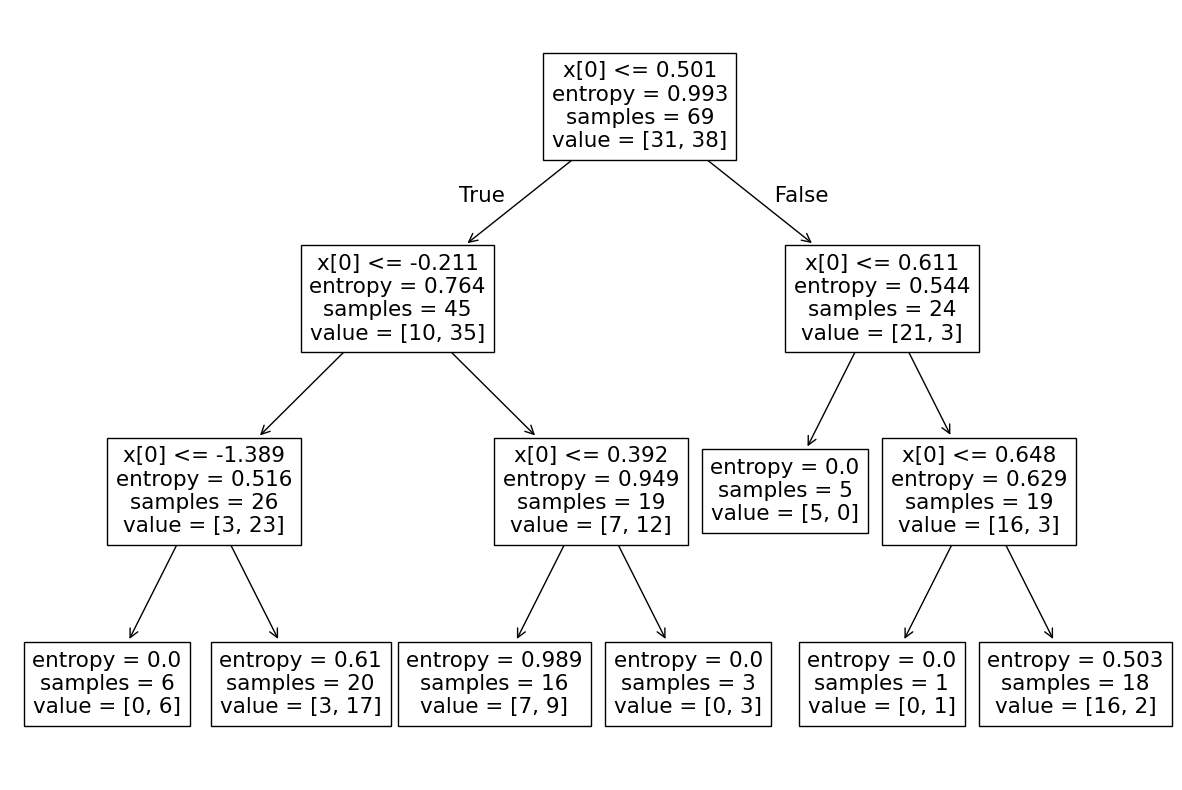

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
model = DecisionTreeClassifier(criterion='entropy',
                             splitter='best',
                             max_depth=3,
                             #min_samples_split=4,
                             #min_samples_leaf=2,
                             #max_features=None,                            
                             #max_leaf_nodes=4
                             )
model = model.fit(X_train_lda_transformed, y_train)
showM = 1
if showM:
    plt.figure(figsize=(15,10))
    plot_tree(model)
    plt.savefig("decision_tree.png")
ydriction = model.predict(X_test_lda_transformed)

TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]


SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))


[2 1 2 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 2 1 2 2 1 1]
Sensitivity(%)=54.54545454545454
Specificity(%)=61.53846153846154
Precision(%)=54.54545454545454
F1Score(%)=54.54545454545454
Accuracy(%)=58.333333333333336


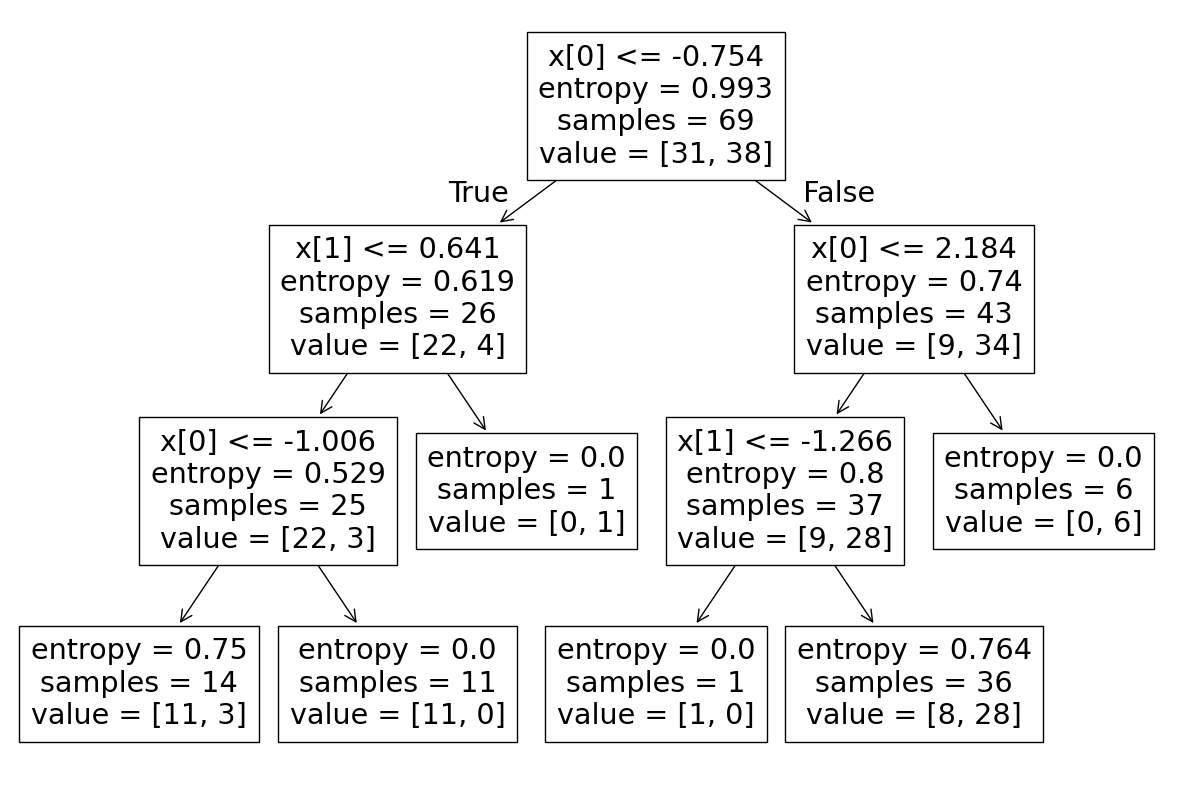

In [15]:
model = model.fit(X_train_do_reduction_pca, y_train)
showM = 1
if showM:
    plt.figure(figsize=(15,10))
    plot_tree(model)
    plt.savefig("decision_tree.png")
ydriction = model.predict(X_test_do_reduction_pca)

TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]
print(y)

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)

print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))

In [16]:
from sklearn.metrics import confusion_matrix
def trainAdaboost(Xtr,ytr,nMod):
    y_convert = np.where(ytr == 1, -1, 1)
    models= np.arange(nMod, dtype=DecisionTreeClassifier)
    N=Xtr.shape[0]
    w=np.ones((N))*(1/N)
   
    
    for i in range(nMod):
        mdl=DecisionTreeClassifier(criterion='gini',max_depth=1)
        mdl.fit(Xtr,y_convert,sample_weight=w)
        pred=mdl.predict(Xtr)
        models[i]=mdl
        err=sum(w*np.heaviside(-y_convert*pred,1))
        alpha=0.5*np.log((1-err)/err)
        models[i].alpha=alpha
        v=np.zeros((N))
        for j in range(N):
            v[j]=w[j]*np.exp(-alpha*y_convert[j]*pred[j])
        
        Sm=np.sum(v)
        w=v/Sm
    return models


def testAdaboost(models,Xte):
    
    nMod=models.shape[0]
    nsamp=Xte.shape[0]
    
    predTot=np.zeros((nMod,nsamp))
    decisionTot=np.zeros((nMod,nsamp))
    for m in range(nMod):
        label=models[m].predict(Xte)
        predTot[m,:]=models[m].alpha*label
    y=np.sign(np.sum(predTot,0))
    y_convert = np.where(y == -1, 1, 2)
    return y_convert
model=trainAdaboost(X_train_lda_transformed, y_train, 5)
ydriction=testAdaboost(model, X_test_lda_transformed)

TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=45.45454545454545
Specificity(%)=46.15384615384615
Precision(%)=41.66666666666667
F1Score(%)=43.47826086956522
Accuracy(%)=45.83333333333333
Confusion Matrix:
 [[5 6]
 [7 6]]


In [18]:
from sklearn.metrics import confusion_matrix

model=trainAdaboost(X_train_do_reduction_pca, y_train, 5)
ydriction=testAdaboost(model, X_test_do_reduction_pca)

TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=54.54545454545454
Specificity(%)=53.84615384615385
Precision(%)=50.0
F1Score(%)=52.17391304347826
Accuracy(%)=54.166666666666664
Confusion Matrix:
 [[6 5]
 [6 7]]


In [22]:
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train_lda_transformed, y_train)
ydriction = modelo.predict(X_test_lda_transformed)
TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=45.45454545454545
Specificity(%)=30.76923076923077
Precision(%)=35.714285714285715
F1Score(%)=40.0
Accuracy(%)=37.5
Confusion Matrix:
 [[5 6]
 [9 4]]


In [23]:
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train_do_reduction_pca, y_train)
ydriction = modelo.predict(X_test_do_reduction_pca)
TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=54.54545454545454
Specificity(%)=61.53846153846154
Precision(%)=54.54545454545454
F1Score(%)=54.54545454545454
Accuracy(%)=58.333333333333336
Confusion Matrix:
 [[6 5]
 [5 8]]


In [34]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear')

svm_model.fit(X_train_lda_transformed, y_train)
ydriction = svm_model.predict(X_test_lda_transformed)

TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=72.72727272727273
Specificity(%)=46.15384615384615
Precision(%)=53.333333333333336
F1Score(%)=61.53846153846153
Accuracy(%)=58.333333333333336
Confusion Matrix:
 [[8 3]
 [7 6]]


In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')

model.fit(X_train_do_reduction_pca, y_train)
ydriction = model.predict(X_test_do_reduction_pca)

TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=63.63636363636363
Specificity(%)=46.15384615384615
Precision(%)=50.0
F1Score(%)=56.00000000000001
Accuracy(%)=54.166666666666664
Confusion Matrix:
 [[7 4]
 [7 6]]


In [35]:
model = svm.SVC(kernel='rbf')
model.fit(X_train_lda_transformed, y_train)

ydriction = model.predict(X_test_lda_transformed)
TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=72.72727272727273
Specificity(%)=46.15384615384615
Precision(%)=53.333333333333336
F1Score(%)=61.53846153846153
Accuracy(%)=58.333333333333336
Confusion Matrix:
 [[8 3]
 [7 6]]


In [36]:
model = svm.SVC(kernel='rbf')
model.fit(X_train_do_reduction_pca, y_train)

ydriction = model.predict(X_test_do_reduction_pca)
TPTr=np.shape(np.where((y[ix_1]==ydriction[ix_1]))[0])[0]
TNTr=np.shape(np.where((y[ix_2]==ydriction[ix_2]))[0])[0]
FPTr=np.shape(np.where((y[ix_2]!=ydriction[ix_2]))[0])[0]
FNTr=np.shape(np.where((y[ix_1]!=ydriction[ix_1]))[0])[0]

SSTr=TPTr/(TPTr+FNTr)
SPTr=TNTr/(TNTr+FPTr)
PRTr=TPTr/(TPTr+FPTr)
F1ScoreTr=2*(PRTr*SSTr)/(PRTr+SSTr)
ACTr=(TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
cm= confusion_matrix(y, ydriction)
print("Sensitivity(%)="+str(SSTr*100))
print("Specificity(%)="+str(SPTr*100))
print("Precision(%)="+str(PRTr*100))
print("F1Score(%)="+str(F1ScoreTr*100))
print("Accuracy(%)="+str(ACTr*100))
print("Confusion Matrix:\n", cm)

Sensitivity(%)=63.63636363636363
Specificity(%)=61.53846153846154
Precision(%)=58.333333333333336
F1Score(%)=60.86956521739131
Accuracy(%)=62.5
Confusion Matrix:
 [[7 4]
 [5 8]]
